In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import zipfile
import pandas as pd 

Importing Simulation Data & Defining Variables

In [20]:
zip_file_path = './sim_data/gt_1a_100.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Assume there is only one CSV file in the zip (you might need to modify this if there are multiple CSV files)
    csv_file_name = zip_ref.namelist()[0]

    # Read the CSV file directly from the zip file into a pandas DataFrame
    with zip_ref.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)
        


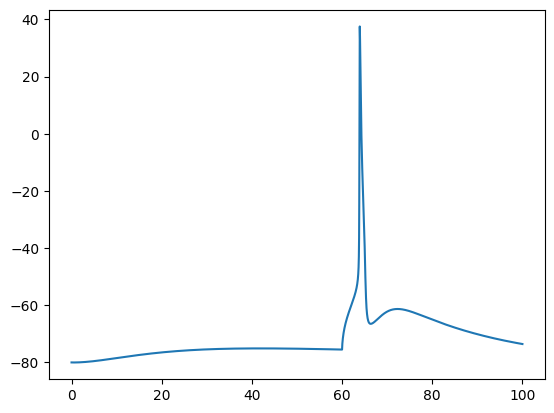

In [21]:
plt.plot(df['time'], df['voltage'], label = 'actual_data')

In [37]:
def parameter_recovery(parameters, target_v, time, I_known):
    # Define the HH model equations
    def alpha_m(V):
        return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

    def beta_m(V):
        return 4.0 * np.exp(-(V + 65.0) / 18.0)

    def alpha_h(V):
        return 0.07 * np.exp(-(V + 65.0) / 20.0)

    def beta_h(V):
        return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

    def alpha_n(V):
        return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

    def beta_n(V):
        return 0.125 * np.exp(-(V + 65) / 80.0)

    def model(y, t, I,  C_m, g_Na, g_K, g_L, E_Na, E_K, E_L):
        V, m, h, n = y
    
        dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
        dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
        dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
        dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    
        return [dVdt, dmdt, dhdt, dndt]
    
    def objective_fnct(parameters, target_v, time, I_known): 
        C_m, g_Na, g_K, g_L, E_Na, E_K, E_L = parameters
    
        sol = odeint(model, [-65, 0.05, 0.6, 0.32], time, args = (I_known, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L))
    
        mse = np.mean((solution[:,0]-target_v)**2)
    
        return mse
    
    def adjoint_model(parameters, target_v, time, I_known):
        C_m, g_Na, g_K, g_L, E_Na, E_K, E_L = parameters

        # Define the impulse function using the known impulse

        # Compute the forward solution
        solution = odeint(model, [-65, 0.05, 0.6, 0.32], time, args=(I_known, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L))

        # Compute the difference between the simulated and target potentials
        error = solution[:, 0] - target_v

        # Compute the adjoint variable (gradient of the objective function)
        adjoint_variable = 2 * error

        return adjoint_variable
    
    bounds = [(1e-6, 1), (1e-6, 100), (1e-6, 100), (1e-6, 10), (-100, 100), (-100, 100), (-100, 100)]

    # Perform the optimization using the adjoint method with bounds
    result = minimize(objective_function, parameters_guess,
                      args=(target_v, time, I_known),
                      method='L-BFGS-B', jac=adjoint_model, bounds=bounds, options={'disp': True})

    # Extract the optimized parameters
    optimized_parameters = result.x

    return optimized_parameters

In [34]:

    def adjoint_model(parameters, target_potential, time, known_impulse):
        C_m, g_Na, g_K, g_L, E_Na, E_K, E_L = parameters

        # Define the impulse function using the known impulse
        def I_stim(t):
            return np.interp(t, time, known_impulse, left=0, right=0)

        # Compute the forward solution
        solution = odeint(model, [-65, 0.05, 0.6, 0.32], time, args=(I_stim, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, lambda t: interp_known_impulse[np.searchsorted(time, t)]))

        # Compute the difference between the simulated and target potentials
        error = solution[:, 0] - target_potential

        # Compute the adjoint variable (gradient of the objective function)
        adjoint_variable = 2 * error


In [35]:
bounds = [(1e-6, 1), (1e-6, 100), (1e-6, 100), (1e-6, 10), (-100, 100), (-100, 100), (-100, 100)]

In [38]:
initial_guess_parameters = [1, 50, 20, 0.5, 50, -77, -54.387]
v_array = (df['voltage'].to_numpy())
i_array = (df['voltage'].to_numpy())
dt = df['time'][1]-df['time'][0]
dur =(df['time'].to_numpy())[-1]
time = np.arange(0, dur, dt)

optimized_parameters = minimizer(v_array, time, i_array, initial_guess_parameters)


TypeError: model() missing 7 required positional arguments: 'C_m', 'g_Na', 'g_K', 'g_L', 'E_Na', 'E_K', and 'E_L'